In [49]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import pyplot
from scipy import stats
from sklearn.preprocessing import MinMaxScaler


In [50]:
dataPath = 'Data/2016-2019(One station)/shair-8781-1-6-1.csv'

def get_data_centralized(dataPath):
    airQualityData=pd.read_csv(dataPath, header=14,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
    airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('O3.*','O3',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('Black Carbon.*','Black Carbon',x), inplace = True)
    airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
    airQualityData= airQualityData.drop('Stop',axis=1)
    one_feature=airQualityData.drop(columns=['Black Carbon','O3'])#
    return one_feature

def arrange_y_x_centralized(dataset):
    data_set=dataset[['PM10','NO2','PM2_5','NOX']]
    X = []
    y = []
    for i in range(5, len(data_set)):
        X.append(data_set.iloc[i-5:i].values)
        y.append(data_set['PM10'].iloc[i])

    X, y = np.array(X), np.array(y)
#     X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X,y

def preprocess_data_centralized(one_feature):
    one_feature.loc[(one_feature['PM10'] <= 0, 'PM10')]=np.nan
    one_feature.loc[(one_feature['NO2'] <= 0, 'NO2')]=np.nan
    one_feature.loc[(one_feature['PM2_5'] <= 0, 'PM2_5')]=np.nan
    one_feature.loc[(one_feature['NOX'] <= 0, 'NOX')]=np.nan
    one_feature=one_feature.fillna(0)
    
    sc = MinMaxScaler(feature_range = (0, 1))
    scaled_down=one_feature.copy()
    scaled_down['PM10']=sc.fit_transform(scaled_down['PM10'].values.reshape(-1, 1))
    scaled_down['NO2']=sc.fit_transform(scaled_down['NO2'].values.reshape(-1, 1))
    scaled_down['PM2_5']=sc.fit_transform(scaled_down['PM2_5'].values.reshape(-1, 1))
    scaled_down['NOX']=sc.fit_transform(scaled_down['NOX'].values.reshape(-1, 1))
    
    train=scaled_down[(scaled_down['Start']<= "2018-12-31 23:00:00")]
    test=scaled_down[(scaled_down['Start'] >= "2019-01-01 00:00:00")]
    train=train.drop('Start',axis = 1)
    test=test.drop('Start',axis = 1)
    test= test.reset_index().drop('index',axis=1)
    
    X_train, y_train=arrange_y_x_centralized(train)
    X_test, y_test=arrange_y_x_centralized(test)
    
    return X_train, y_train, X_test, y_test,sc

X_train, y_train, X_test, y_test,sc_1= preprocess_data_centralized(get_data_centralized(dataPath))

In [51]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Reshape

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = Sequential()
model.add(LSTM(5, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False, stateful=False))
model.add(Dense(1))
# model.add(Reshape([5,1]))
model.compile(loss='MAE', optimizer='adam')

history = model.fit(X_train, y_train, epochs=30,
                    batch_size=72, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False,callbacks=[callback])

Epoch 1/30
487/487 - 1s - loss: 0.0247 - val_loss: 0.0236
Epoch 2/30
487/487 - 1s - loss: 0.0197 - val_loss: 0.0203
Epoch 3/30
487/487 - 1s - loss: 0.0186 - val_loss: 0.0196
Epoch 4/30
487/487 - 1s - loss: 0.0180 - val_loss: 0.0190
Epoch 5/30
487/487 - 1s - loss: 0.0174 - val_loss: 0.0184
Epoch 6/30
487/487 - 1s - loss: 0.0169 - val_loss: 0.0178
Epoch 7/30
487/487 - 1s - loss: 0.0165 - val_loss: 0.0174
Epoch 8/30
487/487 - 1s - loss: 0.0161 - val_loss: 0.0171
Epoch 9/30
487/487 - 1s - loss: 0.0160 - val_loss: 0.0170
Epoch 10/30
487/487 - 1s - loss: 0.0159 - val_loss: 0.0169
Epoch 11/30
487/487 - 1s - loss: 0.0158 - val_loss: 0.0169
Epoch 12/30
487/487 - 1s - loss: 0.0158 - val_loss: 0.0169
Epoch 13/30
487/487 - 1s - loss: 0.0158 - val_loss: 0.0169
Epoch 14/30
487/487 - 1s - loss: 0.0158 - val_loss: 0.0169
Epoch 15/30
487/487 - 1s - loss: 0.0157 - val_loss: 0.0169
Epoch 16/30
487/487 - 1s - loss: 0.0157 - val_loss: 0.0169
Epoch 17/30
487/487 - 1s - loss: 0.0157 - val_loss: 0.0169
Epoch 

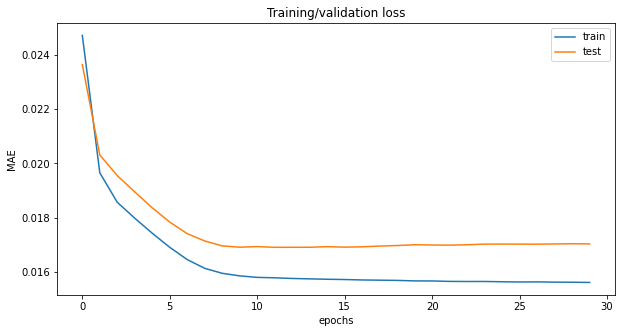

In [52]:
# plot history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'] ,label='train')
plt.plot(history.history['val_loss'],label='test')#orange is validation loss
plt.title('Training/validation loss')
plt.xlabel('epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Testing

In [53]:
dataPath = 'Data/2016-2019(One station)/shair-8781-1-6-1.csv'

def get_data_centralized_test(dataPath):
    airQualityData=pd.read_csv(dataPath, header=14,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
    airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
    airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
    airQualityData= airQualityData.drop('Stop',axis=1)

    return airQualityData

def arrange_y_x_centralized_test(dataset):
    data_set=dataset[['PM10','NO2','PM2_5','NOX']]
    X = []
    y = []
    for i in range(5, len(data_set)):
        X.append(data_set.iloc[i-5:i].values)
        y.append(data_set['PM10'].iloc[i])

    X, y = np.array(X), np.array(y)
#     X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X,y
def preprocess_data_centralized_test(airQualityData):
    one_feature=airQualityData.copy()
    one_feature.loc[(one_feature['PM10'] <= 0, 'PM10')]=np.nan
    one_feature.loc[(one_feature['NO2'] <= 0, 'NO2')]=np.nan
    one_feature.loc[(one_feature['PM2_5'] <= 0, 'PM2_5')]=np.nan
    one_feature.loc[(one_feature['NOX'] <= 0, 'NOX')]=np.nan
    one_feature=one_feature.fillna(0)
    
    sc = MinMaxScaler(feature_range = (0, 1))
    scaled_down=one_feature.copy()
    scaled_down['PM10']=sc.fit_transform(scaled_down['PM10'].values.reshape(-1, 1))
    scaled_down['NO2']=sc.fit_transform(scaled_down['NO2'].values.reshape(-1, 1))
    scaled_down['PM2_5']=sc.fit_transform(scaled_down['PM2_5'].values.reshape(-1, 1))
    scaled_down['NOX']=sc.fit_transform(scaled_down['NOX'].values.reshape(-1, 1))
    
    train=scaled_down[(scaled_down['Start']<= "2018-12-31 23:00:00")]
    test=scaled_down[(scaled_down['Start'] >= "2019-01-01 00:00:00")]
    train=train.drop('Start',axis = 1)
    test=test.drop('Start',axis = 1)
    test= test.reset_index().drop('index',axis=1)
    
    X_train, y_train=arrange_y_x_centralized_test(train)
    X_test, y_test=arrange_y_x_centralized_test(test)
    
    return X_train, y_train, X_test, y_test,sc

_, _, X_test_1, y_test_1,sc_2= preprocess_data_centralized_test(get_data_centralized_test(dataPath))

In [54]:
from math import sqrt
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(sc_2.inverse_transform(y_test_1.reshape(-1,1)),sc_2.inverse_transform(model.predict(X_test_1))))

18.979181875687527

In [55]:
from sklearn.metrics import r2_score
r2_score(sc_1.inverse_transform(y_test.reshape(-1,1)), sc_1.inverse_transform(model.predict(X_test)))

0.7729344803486478

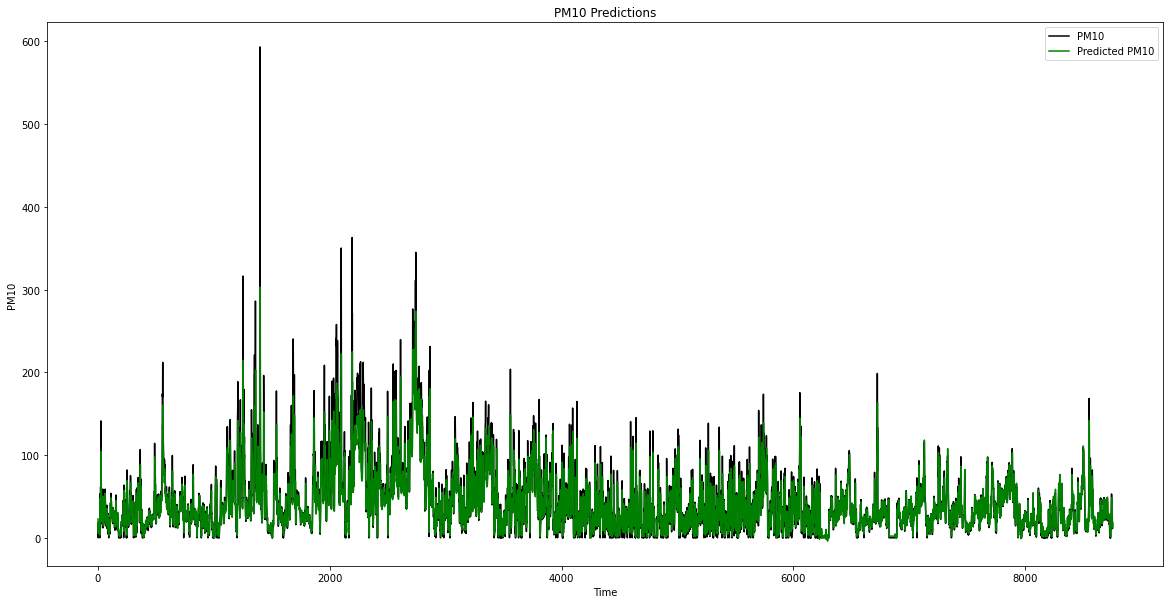

In [62]:
plt.figure(figsize=(20,10))
plt.plot(sc_1.inverse_transform(y_test.reshape(-1,1)), color = 'black', label = 'PM10')
plt.plot(sc_1.inverse_transform(model.predict(X_test)), color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()

# Federated

In [29]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
import math
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_federated as tff

In [30]:
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [31]:
from sklearn.preprocessing import MinMaxScaler

dataPath = 'Data/2016-2019(NO2, NOX, PM2.5)'

def get_data_federated(dataPath):
    
    listOfDataFrames=[]
    stations=os.listdir(dataPath)
    for station in stations:
        print("Processing year: "+ dataPath +" station: "+station)
        airQualityData=pd.read_csv(dataPath+'\\'+station, header=12,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
        airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
        airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
        airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
        airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
        listOfDataFrames.append(airQualityData)
    return listOfDataFrames

def preprocess_federated(listOfDataFrames):
    list_of_training=[]
    list_of_testing=[]
    for index, airData in enumerate(listOfDataFrames):
        df= airData
        #df['origin']="station{}".format(index)

        df.loc[(df['PM10'] <= 0, 'PM10')]=np.nan
        df.loc[(df['NO2'] <= 0, 'NO2')]=np.nan
        df.loc[(df['PM2_5'] <= 0, 'PM2_5')]=np.nan
        df.loc[(df['NOX'] <= 0, 'NOX')]=np.nan
        df=df.fillna(0)


        sc = MinMaxScaler(feature_range = (0, 1))
        scaled_down=df.copy()
        scaled_down['PM10']=sc.fit_transform(scaled_down['PM10'].values.reshape(-1, 1))
        scaled_down['NO2']=sc.fit_transform(scaled_down['NO2'].values.reshape(-1, 1))
        scaled_down['PM2_5']=sc.fit_transform(scaled_down['PM2_5'].values.reshape(-1, 1))
        scaled_down['NOX']=sc.fit_transform(scaled_down['NOX'].values.reshape(-1, 1))

        train=scaled_down[(scaled_down['Start']<= "2018-12-31 23:00:00")]
        test=scaled_down[(scaled_down['Start'] >= "2019-01-01 00:00:00")]
        train=train.drop('Start',axis = 1)
        test=test.drop('Start',axis = 1)
        test= test.reset_index().drop('index',axis=1)

        list_of_training.append(train)
        list_of_testing.append(test)
    return list_of_training,list_of_testing
list_of_training,list_of_testing= preprocess_federated(get_data_federated(dataPath))

Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-18644-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8779-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8780-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8781-1-6-1.csv


In [32]:
def arrange_y_x_federated(list_of_data):
    x_list=[]
    y_list=[]
    for dataset in list_of_data:
        data_set=dataset[['PM10','NO2','PM2_5','NOX']]
        X = []
        y = []
        for i in range(5, len(data_set)):
            X.append(data_set.iloc[i-5:i].values)
            y.append(data_set['PM10'].iloc[i])

        X, y = np.array(X), np.array(y)
#         X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        
#         X_train=X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        print(X.shape)
        x_list.append(X)
        y_list.append(y)
    return x_list,y_list

In [33]:
x_train_list,y_train_list=arrange_y_x_federated(list_of_training)
x_test_list,y_test_list=arrange_y_x_federated(list_of_testing)

(35059, 5, 4)
(35059, 5, 4)
(35059, 5, 4)
(35059, 5, 4)
(8754, 5, 4)
(8754, 5, 4)
(8754, 5, 4)
(8754, 5, 4)


In [34]:
import collections
import tensorflow as tf
from sklearn.model_selection import train_test_split

NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
      return collections.OrderedDict(x=element['x'], y=element['y'])

  return dataset.batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

# produce datasets for each origin
def make_federated_data(X_train, y_train, X_test, y_test):
        
        train_dataset = tf.data.Dataset.from_tensor_slices(
            ({'x': X_train, 'y': y_train}))
        
        test_dataset = tf.data.Dataset.from_tensor_slices(
            ({'x': X_test, 'y': y_test}))

        preprocessed_train_dataset = preprocess(train_dataset)
        preprocessed_test_dataset = preprocess(test_dataset)
        
        
        
        return preprocessed_train_dataset, preprocessed_test_dataset 

def prepapre_all_federated_data(x_train_list,y_train_list,x_test_list,y_test_list):
    train_datasets = []
    test_datasets = []
    for X_train,y_train, X_test, y_test in zip(x_train_list,y_train_list,x_test_list,y_test_list):
        preprocessed_train_dataset,preprocessed_test_dataset=make_federated_data(X_train, y_train, X_test, y_test)
        train_datasets.append(preprocessed_train_dataset)
        test_datasets.append(preprocessed_test_dataset)    
    
    return train_datasets, test_datasets

In [35]:
train_datasets, test_datasets = prepapre_all_federated_data(x_train_list,y_train_list,x_test_list,y_test_list)

In [36]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
def build_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(5,4)))
    model.add(Dense(1))
    return model

In [37]:
def create_tff_model():
      return tff.learning.from_keras_model(build_model(), 
                                       input_spec=train_datasets[0].element_spec,
                                       loss=tf.keras.losses.MeanAbsoluteError(),
                                       metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [38]:
print("Create averaging process")
iterative_process = tff.learning.build_federated_averaging_process(model_fn=create_tff_model,
                                                                   client_optimizer_fn = lambda: tf.keras.optimizers.SGD(0.002))

Create averaging process


In [39]:
print("Initzialize averaging process")
state = iterative_process.initialize()

print("Start iterations")
for _ in range(10):
  state, metrics = iterative_process.next(state, train_datasets)
  print('metrics={}'.format(metrics))

Initzialize averaging process
Start iterations
metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('mean_absolute_error', 0.03602603), ('loss', 0.03602681)]))])
metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('mean_absolute_error', 0.029669218), ('loss', 0.029669786)]))])
metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('mean_absolute_error', 0.026960095), ('loss', 0.026960593)]))])
metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('mean_absolute_error', 0.025259605), ('loss', 0.025260067)]))])
metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()),

In [40]:
# Global model evaluated over all clients
evaluation = tff.learning.build_federated_evaluation(model_fn=create_tff_model)
test_metrics = evaluation(state.model, test_datasets)
print(test_metrics)

OrderedDict([('mean_absolute_error', 0.021147983), ('loss', 0.021140775)])
